# Exploration of Models

### Imports

In [4]:
import pickle
import random
import re
import time
import warnings
from itertools import cycle

import keras
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import ClusterCentroids, RandomUnderSampler
from keras.callbacks import EarlyStopping
from keras.layers import LSTM, Dense, Dropout, Embedding, SpatialDropout1D
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from nltk.stem import WordNetLemmatizer
from scipy import interp
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import (
    CountVectorizer,
    TfidfTransformer,
    TfidfVectorizer,
)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from tqdm import tqdm
from transformers import BertTokenizer, TFAutoModel

warnings.filterwarnings("ignore")

nltk.download("wordnet")

[nltk_data] Downloading package wordnet to /Users/brandon/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Import Data

In [5]:
df = pd.read_csv("~/FireClub/ML/Moderation/data/processed/processed_stopwords.csv")

In [6]:
df.head(10)

,class,text
0,2,RT mayasolovely As woman complain cleaning hou...
1,1,RT mleew boy dats coldtyga dwn bad cuffin dat ...
2,1,RT UrKindOfBrand Dawg RT sbabylife You ever fu...
3,1,RT CGAnderson vivabased look like tranny
4,1,RT ShenikaRoberts The shit hear might true mig...
5,1,TMadisonx The shit blows meclaim faithful some...
6,1,BrighterDays I sit HATE another bitch I got mu...
7,1,selfiequeenbri cause I tired big bitches comin...
8,1,amp might get ya bitch back amp thats
9,1,rhythmixx hobbies include fighting Mariambitch


In [7]:
df["class"].value_counts()

2    205640
1     39145
0      3547
Name: class, dtype: int64

In [8]:
df.dropna(inplace=True)

## Preprocessing

### Lemmatization

In [9]:
token_pattern = re.compile(r"(?u)\b\w\w+\b")


class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()

    def __call__(self, doc):
        return [
            self.wnl.lemmatize(t)
            for t in doc.split()
            if len(t) >= 2 and re.match("[a-z].*", t) and re.match(token_pattern, t)
        ]

### Vectorization Functions

In [10]:
def tfidf_vectorizer(data, max_df=0.80, min_df=600):
    tfidf_vectorizer = TfidfVectorizer(
        input="content",
        analyzer="word",
        tokenizer=LemmaTokenizer(),
        max_df=max_df,
        min_df=min_df,
        ngram_range=(1, 2),
    )
    tfidf = tfidf_vectorizer.fit_transform(data)
    return tfidf, tfidf_vectorizer.get_feature_names(), tfidf_vectorizer


def count_vectorizer(data, max_df=0.80, min_df=700):
    count_vectorizer = CountVectorizer(
        input="content",
        analyzer="word",
        tokenizer=LemmaTokenizer(),
        max_df=max_df,
        min_df=min_df,
        ngram_range=(1, 2),
    )
    count = count_vectorizer.fit_transform(data)
    return count, count_vectorizer.get_feature_names(), count_vectorizer

### TF-IDF Vectorization

In [11]:
start = time.time()
tfidf_trained = tfidf_vectorizer(df["text"])
print("Time to vectorize: ", time.time() - start)
tfidf = tfidf_trained[0]
vocab_tfidf = tfidf_trained[1]
len(vocab_tfidf)

Time to vectorize:  64.11924242973328


1910

### Save TF-IDF Vectorizer

In [13]:
pickle.dump(
    tfidf_trained[2].vocabulary_,
    open("/Users/brandon/FireClub/ML/Moderation/models/tfidf_features.pkl", "wb"),
)

### Count Vectorization

In [ ]:
start = time.time()
count_trained = count_vectorizer(df["text"])
print("Time to vectorize: ", time.time() - start)
count = count_trained[0]
vocab_count = count_trained[1]
len(vocab_count)

### Save Count Vectorizer

In [ ]:
pickle.dump(
    count_trained[2].vocabulary_,
    open("/Users/brandon/FireClub/ML/Moderation/model/count_features.pkl", "wb"),
)

### Output Encoding

In [14]:
def encode_outputs(y):
    encoder = LabelEncoder()
    encoder.fit(y)
    encoded_y = encoder.transform(y)
    return np_utils.to_categorical(encoded_y), encoded_y

In [15]:
encoded = encode_outputs(df["class"])
y = encoded[0]

In [16]:
encoded

(array([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        ...,
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]], dtype=float32),
 array([2, 1, 1, ..., 2, 2, 2]))

### TF-IDF Train-Test Split

In [29]:
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(
    tfidf.toarray(), y, test_size=0.2, random_state=13
)

In [30]:
print(X_train_tfidf.shape)
print(X_test_tfidf.shape)
print(y_train_tfidf.shape)
print(y_test_tfidf.shape)

(198613, 1910)
(49654, 1910)
(198613, 3)
(49654, 3)


### Count Train-Test Split

In [31]:
X_train_count, X_test_count, y_train_count, y_test_count = train_test_split(
    count.toarray(), y, test_size=0.2, random_state=13
)

In [32]:
print(X_train_count.shape)
print(X_test_count.shape)
print(y_train_count.shape)
print(y_test_count.shape)

(198613, 1658)
(49654, 1658)
(198613, 3)
(49654, 3)


### Random Oversampling TF-IDF

In [33]:
ros = RandomOverSampler(random_state=0)
X_resampled_tfidf, y_resampled_tfidf = ros.fit_resample(X_train_tfidf, y_train_tfidf)
pd.DataFrame(y_resampled_tfidf.argmax(axis=1))[0].value_counts()

0    164574
1    164574
2    164574
Name: 0, dtype: int64

### Random Oversampling Count

In [34]:
ros = RandomOverSampler(random_state=0)
X_resampled_count, y_resampled_count = ros.fit_resample(X_train_count, y_train_count)
pd.DataFrame(y_resampled_count.argmax(axis=1))[0].value_counts()

0    164574
1    164574
2    164574
Name: 0, dtype: int64

## Multilayer Perceptron Neural Network

### Predictions

In [31]:
def mlp(
    X_train, y_train, X_test, name, class_weight=None, epochs=15, batch_size=15000,
):
    model = Sequential()
    model.add(Dense(100, input_shape=(X_train.shape[1],), activation="relu"))
    model.add(Dense(50, activation="relu"))
    model.add(Dense(250, activation="relu"))
    model.add(Dense(25, activation="relu"))
    model.add(Dense(y_train.shape[1], activation="softmax"))
    model.compile(
        loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    model.summary()

    model.fit(
        X_train,
        y_train,
        class_weight=class_weight,
        epochs=epochs,
        batch_size=batch_size,
    )
    print(model.evaluate(X_train, y_train))
    model.save("/Users/brandon/FireClub/ML/Moderation/model/{}".format(name))
    return np.argmax(model.predict(X_test), axis=1), model

In [208]:
weights = {0: 57.8, 1: 5.3, 2: 2.0}
y_pred_tfidf = mlp(
    model, X_train_tfidf, y_train_tfidf, X_test_tfidf, "tfidf_model", weights
)

Epoch 1/15
14/14 [==============================] - 3s 106ms/step - loss: 3.5950 - accuracy: 0.5936
Epoch 2/15
14/14 [==============================] - 2s 106ms/step - loss: 3.2064 - accuracy: 0.8297
Epoch 3/15
14/14 [==============================] - 2s 112ms/step - loss: 2.5434 - accuracy: 0.8209
Epoch 4/15
14/14 [==============================] - 2s 121ms/step - loss: 2.0423 - accuracy: 0.8154
Epoch 5/15
14/14 [==============================] - 2s 127ms/step - loss: 1.6591 - accuracy: 0.8622
Epoch 6/15
14/14 [==============================] - 2s 165ms/step - loss: 1.4418 - accuracy: 0.8876
Epoch 7/15
14/14 [==============================] - 2s 141ms/step - loss: 1.3479 - accuracy: 0.8962
Epoch 8/15
14/14 [==============================] - 2s 134ms/step - loss: 1.2635 - accuracy: 0.9026
Epoch 9/15
14/14 [==============================] - 2s 140ms/step - loss: 1.2299 - accuracy: 0.9046
Epoch 10/15
14/14 [==============================] - 2s 122ms/step - loss: 1.1578 - accuracy: 0.9079

In [32]:
y_pred_over_tfidf, model = mlp(
    X_resampled_tfidf, y_resampled_tfidf, X_test_tfidf, "tfidf_oversampled_model-2",
)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 100)               191100    
_________________________________________________________________
dense_16 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_17 (Dense)             (None, 250)               12750     
_________________________________________________________________
dense_18 (Dense)             (None, 25)                6275      
_________________________________________________________________
dense_19 (Dense)             (None, 3)                 78        
Total params: 215,253
Trainable params: 215,253
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
33/33 [==============================] - 13s 324ms/step - loss: 1.0301 - accuracy: 0.5688
Epoch 2/15
33

In [212]:
y_pred_count = mlp(
    model, X_train_count, y_train_count, X_test_count, "count_model", weights
)

Epoch 1/15
14/14 [==============================] - 6s 241ms/step - loss: 3.4764 - accuracy: 0.7154
Epoch 2/15
14/14 [==============================] - 2s 151ms/step - loss: 2.9025 - accuracy: 0.8297
Epoch 3/15
14/14 [==============================] - 2s 155ms/step - loss: 2.4929 - accuracy: 0.8129
Epoch 4/15
14/14 [==============================] - 2s 152ms/step - loss: 2.1183 - accuracy: 0.8279
Epoch 5/15
14/14 [==============================] - 2s 153ms/step - loss: 1.7244 - accuracy: 0.8765
Epoch 6/15
14/14 [==============================] - 2s 166ms/step - loss: 1.4980 - accuracy: 0.8945
Epoch 7/15
14/14 [==============================] - 2s 151ms/step - loss: 1.3252 - accuracy: 0.9023
Epoch 8/15
14/14 [==============================] - 2s 157ms/step - loss: 1.2671 - accuracy: 0.9078
Epoch 9/15
14/14 [==============================] - 2s 153ms/step - loss: 1.1585 - accuracy: 0.9107
Epoch 10/15
14/14 [==============================] - 2s 154ms/step - loss: 1.0970 - accuracy: 0.9152

In [29]:
y_pred_over_count = mlp(
    model, X_resampled_count, y_resampled_count, X_test_count, "count_oversampled_model"
)

NameError: name 'model' is not defined

## MLP NN Analysis

### MLP NN Class Accuracies

In [219]:
def class_accuracies(y_test, y_pred, X_test):
    ind = 0
    while ind < 3:
        t = 0
        c = 0
        i = 0
        while i < X_test.shape[0]:
            if y_pred[i] == ind:
                t += 1
                if y_test[i][y_pred[i]] == 1.0:
                    c += 1
            i += 1
        if t != 0:
            print("Class {} Accuaracy: {}".format(ind, c / t))
        else:
            print("Class {} Accuaracy: 0.0".format(ind))
        ind += 1

In [220]:
print("TF-IDF:")
class_accuracies(y_test_tfidf, y_pred_tfidf, X_test_tfidf)

TF-IDF:
Class 0 Accuaracy: 0.20313986679352997
Class 1 Accuaracy: 0.7967479674796748
Class 2 Accuaracy: 0.9610466260082628


In [221]:
print("TF-IDF Oversampled:")
class_accuracies(y_test_tfidf, y_pred_over_tfidf, X_test_tfidf)

TF-IDF Oversampled:
Class 0 Accuaracy: 0.26436781609195403
Class 1 Accuaracy: 0.6980631773115057
Class 2 Accuaracy: 0.9604727281812958


In [222]:
print("Count:")
class_accuracies(y_test_count, y_pred_count, X_test_count)

Count:
Class 0 Accuaracy: 0.20629567172568858
Class 1 Accuaracy: 0.7269611074489123
Class 2 Accuaracy: 0.9586001489203276


In [223]:
print("Count Oversampled:")
class_accuracies(y_test_count, y_pred_over_count, X_test_count)

Count Oversampled:
Class 0 Accuaracy: 0.13653136531365315
Class 1 Accuaracy: 0.7070181953212031
Class 2 Accuaracy: 0.9551136650032763


### Confusion Matrix and Statistics

In [44]:
def confusion_matrix_plot(y_test, y_pred, n_classes, title="Confusion Matrix"):
    cleaned_y_test = y_test.argmax(axis=1)
    confusion = confusion_matrix(cleaned_y_test, y_pred)
    classes = [i for i in range(n_classes)]

    df_cm = pd.DataFrame(confusion, index=classes, columns=classes)
    plt.figure(figsize=(10, 7))
    sns.heatmap(df_cm, cmap="coolwarm", annot=True, fmt="d")
    plt.ylabel("True Values")
    plt.xlabel("Predicted Values")
    plt.title(title)
    plt.show()


def stats(y_test, y_pred, n_classes):
    cleaned_y_test = y_test.argmax(axis=1)
    print("\nAccuracy: {:.2f}\n".format(accuracy_score(cleaned_y_test, y_pred)))

    print(
        "Micro Precision: {:.2f}".format(
            precision_score(cleaned_y_test, y_pred, average="micro")
        )
    )
    print(
        "Micro Recall: {:.2f}".format(
            recall_score(cleaned_y_test, y_pred, average="micro")
        )
    )
    print(
        "Micro F1-score: {:.2f}\n".format(
            f1_score(cleaned_y_test, y_pred, average="micro")
        )
    )

    print(
        "Macro Precision: {:.2f}".format(
            precision_score(cleaned_y_test, y_pred, average="macro")
        )
    )
    print(
        "Macro Recall: {:.2f}".format(
            recall_score(cleaned_y_test, y_pred, average="macro")
        )
    )
    print(
        "Macro F1-score: {:.2f}\n".format(
            f1_score(cleaned_y_test, y_pred, average="macro")
        )
    )

    print(
        "Weighted Precision: {:.2f}".format(
            precision_score(cleaned_y_test, y_pred, average="weighted")
        )
    )
    print(
        "Weighted Recall: {:.2f}".format(
            recall_score(cleaned_y_test, y_pred, average="weighted")
        )
    )
    print(
        "Weighted F1-score: {:.2f}".format(
            f1_score(cleaned_y_test, y_pred, average="weighted")
        )
    )

    classes = ["Class " + str(i) for i in range(1, n_classes + 1)]
    print("\nClassification Report\n")
    print(classification_report(cleaned_y_test, y_pred, target_names=classes))

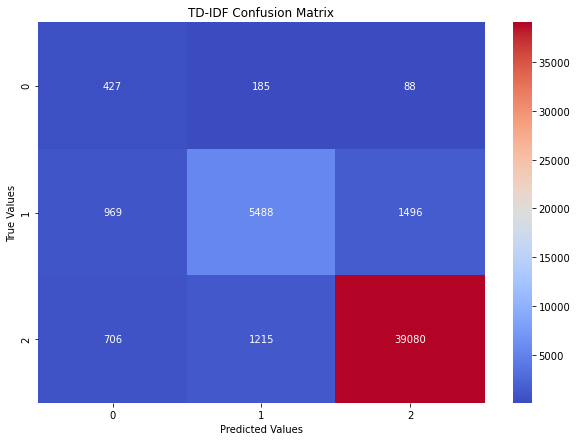


Accuracy: 0.91

Micro Precision: 0.91
Micro Recall: 0.91
Micro F1-score: 0.91

Macro Precision: 0.65
Macro Recall: 0.75
Macro F1-score: 0.67

Weighted Precision: 0.92
Weighted Recall: 0.91
Weighted F1-score: 0.91

Classification Report

              precision    recall  f1-score   support

     Class 1       0.20      0.61      0.30       700
     Class 2       0.80      0.69      0.74      7953
     Class 3       0.96      0.95      0.96     41001

    accuracy                           0.91     49654
   macro avg       0.65      0.75      0.67     49654
weighted avg       0.92      0.91      0.91     49654



In [229]:
confusion_matrix_plot(y_test_tfidf, y_pred_tfidf, 3, title="TD-IDF Confusion Matrix")
stats(y_test_tfidf, y_pred_tfidf, 3)

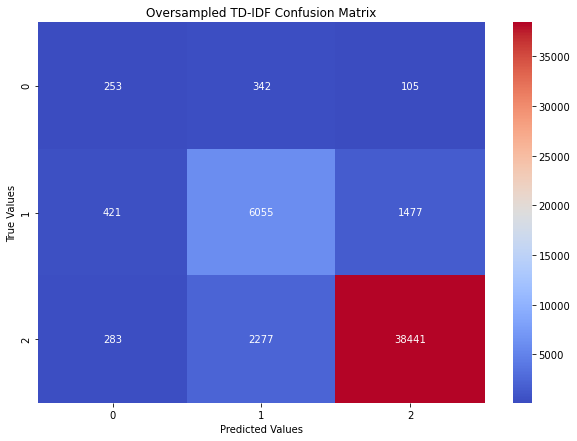


Accuracy: 0.90

Micro Precision: 0.90
Micro Recall: 0.90
Micro F1-score: 0.90

Macro Precision: 0.64
Macro Recall: 0.69
Macro F1-score: 0.66

Weighted Precision: 0.91
Weighted Recall: 0.90
Weighted F1-score: 0.90

Classification Report

              precision    recall  f1-score   support

     Class 1       0.26      0.36      0.31       700
     Class 2       0.70      0.76      0.73      7953
     Class 3       0.96      0.94      0.95     41001

    accuracy                           0.90     49654
   macro avg       0.64      0.69      0.66     49654
weighted avg       0.91      0.90      0.90     49654



In [225]:
confusion_matrix_plot(
    y_test_tfidf, y_pred_over_tfidf, 3, title="Oversampled TD-IDF Confusion Matrix"
)
stats(y_test_tfidf, y_pred_over_tfidf, 3)

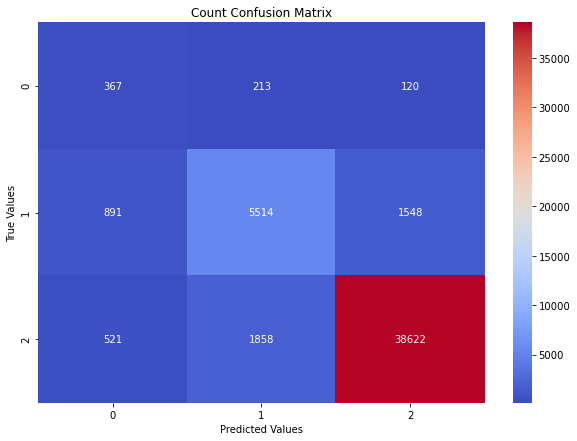


Accuracy: 0.90

Micro Precision: 0.90
Micro Recall: 0.90
Micro F1-score: 0.90

Macro Precision: 0.63
Macro Recall: 0.72
Macro F1-score: 0.65

Weighted Precision: 0.91
Weighted Recall: 0.90
Weighted F1-score: 0.90

Classification Report

              precision    recall  f1-score   support

     Class 1       0.21      0.52      0.30       700
     Class 2       0.73      0.69      0.71      7953
     Class 3       0.96      0.94      0.95     41001

    accuracy                           0.90     49654
   macro avg       0.63      0.72      0.65     49654
weighted avg       0.91      0.90      0.90     49654



In [226]:
confusion_matrix_plot(y_test_count, y_pred_count, 3, title="Count Confusion Matrix")
stats(y_test_count, y_pred_count, 3)

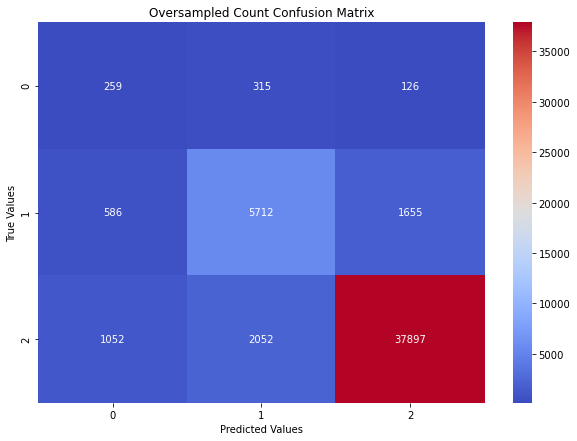


Accuracy: 0.88

Micro Precision: 0.88
Micro Recall: 0.88
Micro F1-score: 0.88

Macro Precision: 0.60
Macro Recall: 0.67
Macro F1-score: 0.62

Weighted Precision: 0.90
Weighted Recall: 0.88
Weighted F1-score: 0.89

Classification Report

              precision    recall  f1-score   support

     Class 1       0.14      0.37      0.20       700
     Class 2       0.71      0.72      0.71      7953
     Class 3       0.96      0.92      0.94     41001

    accuracy                           0.88     49654
   macro avg       0.60      0.67      0.62     49654
weighted avg       0.90      0.88      0.89     49654



In [227]:
confusion_matrix_plot(
    y_test_count, y_pred_over_count, 3, title="Oversampled Count Confusion Matrix"
)
stats(y_test_count, y_pred_over_count, 3)

### Test Model with Inputs

In [33]:
transformer = TfidfTransformer()
loaded_vec = TfidfVectorizer(decode_error="replace", vocabulary=vocab_tfidf)
test_tfidf = transformer.fit_transform(
    loaded_vec.fit_transform(np.array(["what are you a homo", "I love you"]))
)

In [35]:
preds = model.predict(test_tfidf.toarray())

In [38]:
for comment in preds:
    for classification, pred in enumerate(comment):
        print(f"{classification}: {pred:0.3}")

0: 2.11e-06
1: 0.994
2: 0.00628
0: 0.454
1: 0.195
2: 0.35


## Sklearn Classifiers

### Classifer Models Exploration TF-IDF

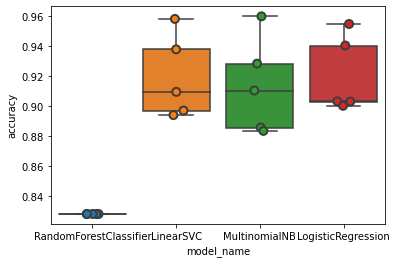

In [232]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, tfidf, df["class"], scoring="accuracy", cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=["model_name", "fold_idx", "accuracy"])

sns.boxplot(x="model_name", y="accuracy", data=cv_df)
sns.stripplot(
    x="model_name",
    y="accuracy",
    data=cv_df,
    size=8,
    jitter=True,
    edgecolor="gray",
    linewidth=2,
)
plt.show()

### Model Accuracies TF-IDF

In [233]:
cv_df.groupby("model_name").accuracy.mean()

model_name
LinearSVC                 0.919151
LogisticRegression        0.920150
MultinomialNB             0.913391
RandomForestClassifier    0.828040
Name: accuracy, dtype: float64

### Classifer Models Exploration Count

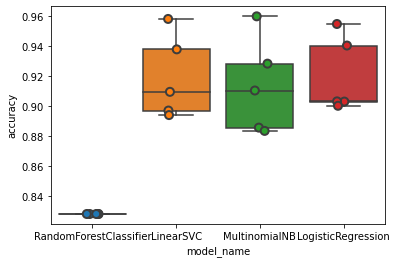

In [234]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, tfidf, df["class"], scoring="accuracy", cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=["model_name", "fold_idx", "accuracy"])

sns.boxplot(x="model_name", y="accuracy", data=cv_df)
sns.stripplot(
    x="model_name",
    y="accuracy",
    data=cv_df,
    size=8,
    jitter=True,
    edgecolor="gray",
    linewidth=2,
)
plt.show()

### Model Accuracies Count

In [235]:
cv_df.groupby("model_name").accuracy.mean()

model_name
LinearSVC                 0.919151
LogisticRegression        0.920150
MultinomialNB             0.913391
RandomForestClassifier    0.828040
Name: accuracy, dtype: float64

## Logistic Regression

In [35]:
def logreg(X_train, y_train, X_test, name):
    clf = LogisticRegression(random_state=0)
    clf.fit(X_train, y_train.argmax(axis=1))
    pickle.dump(
        clf,
        open("/Users/brandon/FireClub/ML/Moderation/model/{}.pkl".format(name), "wb",),
    )
    return clf.predict(X_test)

### Predictions

In [36]:
y_pred_log_tfidf = logreg(
    X_train_tfidf, y_train_tfidf, X_test_tfidf, "logisitic_regression_model_tfidf"
)

In [37]:
y_pred_log_over_tfidf = logreg(
    X_resampled_tfidf,
    y_resampled_tfidf,
    X_test_tfidf,
    "logisitic_regression_model_oversampled_tfidf",
)

In [38]:
y_pred_log_count = logreg(
    X_train_count, y_train_count, X_test_count, "logisitic_regression_model_count",
)

In [39]:
y_pred_log_over_count = logreg(
    X_resampled_count,
    y_resampled_count,
    X_test_count,
    "logisitic_regression_model_oversampled_count",
)

### Confusion Matrix and Statistics

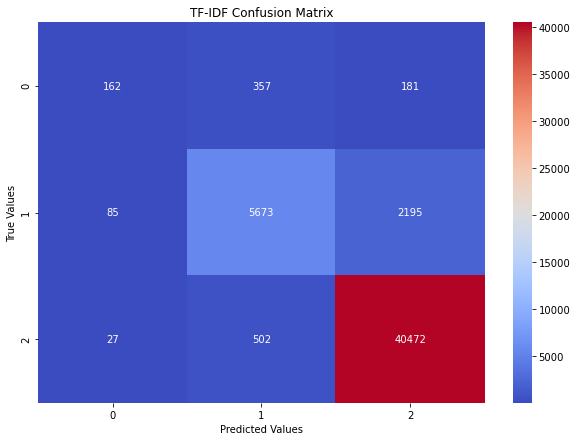


Accuracy: 0.93

Micro Precision: 0.93
Micro Recall: 0.93
Micro F1-score: 0.93

Macro Precision: 0.80
Macro Recall: 0.64
Macro F1-score: 0.69

Weighted Precision: 0.93
Weighted Recall: 0.93
Weighted F1-score: 0.93

Classification Report

              precision    recall  f1-score   support

     Class 1       0.59      0.23      0.33       700
     Class 2       0.87      0.71      0.78      7953
     Class 3       0.94      0.99      0.97     41001

    accuracy                           0.93     49654
   macro avg       0.80      0.64      0.69     49654
weighted avg       0.93      0.93      0.93     49654



In [45]:
confusion_matrix_plot(y_test_tfidf, y_pred_log_tfidf, 3, "TF-IDF Confusion Matrix")
stats(y_test_tfidf, y_pred_log_tfidf, 3)

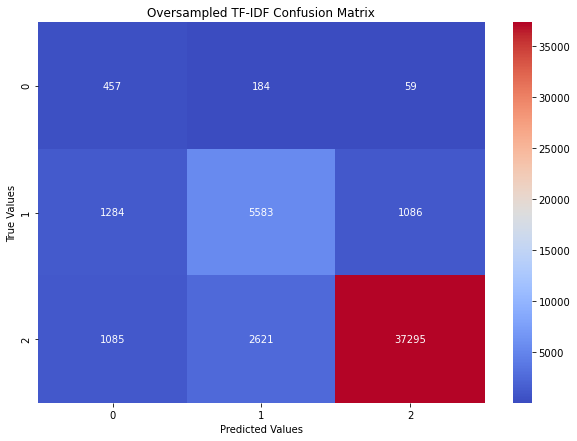


Accuracy: 0.87

Micro Precision: 0.87
Micro Recall: 0.87
Micro F1-score: 0.87

Macro Precision: 0.60
Macro Recall: 0.75
Macro F1-score: 0.63

Weighted Precision: 0.91
Weighted Recall: 0.87
Weighted F1-score: 0.89

Classification Report

              precision    recall  f1-score   support

     Class 1       0.16      0.65      0.26       700
     Class 2       0.67      0.70      0.68      7953
     Class 3       0.97      0.91      0.94     41001

    accuracy                           0.87     49654
   macro avg       0.60      0.75      0.63     49654
weighted avg       0.91      0.87      0.89     49654



In [46]:
confusion_matrix_plot(
    y_test_tfidf, y_pred_log_over_tfidf, 3, "Oversampled TF-IDF Confusion Matrix"
)
stats(y_test_tfidf, y_pred_log_over_tfidf, 3)

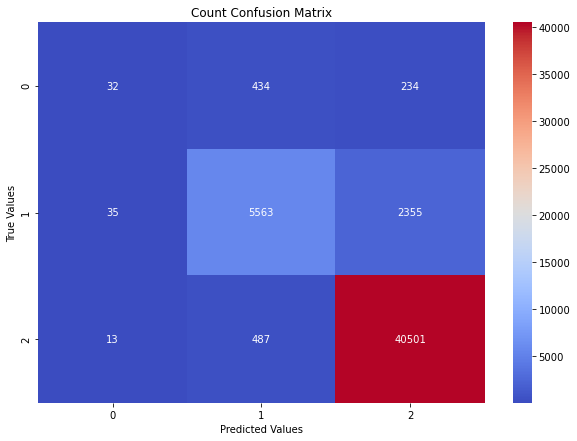


Accuracy: 0.93

Micro Precision: 0.93
Micro Recall: 0.93
Micro F1-score: 0.93

Macro Precision: 0.73
Macro Recall: 0.58
Macro F1-score: 0.61

Weighted Precision: 0.92
Weighted Recall: 0.93
Weighted F1-score: 0.92

Classification Report

              precision    recall  f1-score   support

     Class 1       0.40      0.05      0.08       700
     Class 2       0.86      0.70      0.77      7953
     Class 3       0.94      0.99      0.96     41001

    accuracy                           0.93     49654
   macro avg       0.73      0.58      0.61     49654
weighted avg       0.92      0.93      0.92     49654



In [47]:
confusion_matrix_plot(y_test_count, y_pred_log_count, 3, "Count Confusion Matrix")
stats(y_test_count, y_pred_log_count, 3)

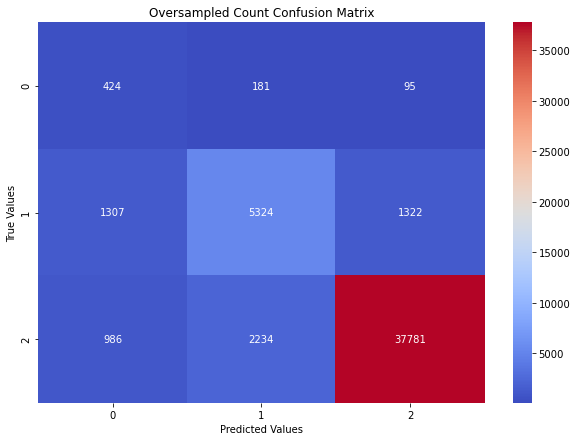


Accuracy: 0.88

Micro Precision: 0.88
Micro Recall: 0.88
Micro F1-score: 0.88

Macro Precision: 0.60
Macro Recall: 0.73
Macro F1-score: 0.62

Weighted Precision: 0.91
Weighted Recall: 0.88
Weighted F1-score: 0.89

Classification Report

              precision    recall  f1-score   support

     Class 1       0.16      0.61      0.25       700
     Class 2       0.69      0.67      0.68      7953
     Class 3       0.96      0.92      0.94     41001

    accuracy                           0.88     49654
   macro avg       0.60      0.73      0.62     49654
weighted avg       0.91      0.88      0.89     49654



In [48]:
confusion_matrix_plot(
    y_test_count, y_pred_log_over_count, 3, "Oversampled Count Confusion Matrix"
)
stats(y_test_count, y_pred_log_over_count, 3)

## LSTM

In [6]:
df["text"] = df["text"].str.lower()

In [7]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 500
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 512
# This is fixed.
EMBEDDING_DIM = 25

tokenizer = Tokenizer(
    num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True
)
tokenizer.fit_on_texts(df["text"].values)
word_index = tokenizer.word_index
print("Found %s unique tokens." % len(word_index))

Found 389145 unique tokens.


In [8]:
X = tokenizer.texts_to_sequences(df["text"].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print("Shape of data tensor:", X.shape)

Shape of data tensor: (248267, 512)


In [9]:
Y = pd.get_dummies(df["class"]).values
print("Shape of label tensor:", Y.shape)

Shape of label tensor: (248267, 3)


In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.20, random_state=13
)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(198613, 512) (198613, 3)
(49654, 512) (49654, 3)


In [11]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 512, 25)           12500     
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 512, 25)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               50400     
_________________________________________________________________
dense (Dense)                (None, 3)                 303       
Total params: 63,203
Trainable params: 63,203
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
epochs = 5
batch_size = 250000

history = model.fit(
    X_train,
    Y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.1,
    callbacks=[EarlyStopping(monitor="val_loss", patience=3, min_delta=0.0001)],
)

Epoch 1/5


## BERT

In [10]:
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

In [11]:
def tokenize(sentence):
    tokens = tokenizer.encode_plus(
        sentence,
        max_length=1024,
        truncation=True,
        padding="max_length",
        add_special_tokens=True,
        return_token_type_ids=False,
        return_tensors="tf",
    )
    return tokens["input_ids"], tokens["attention_mask"]

In [12]:
Xids = np.zeros((len(df), 1024))
Xmask = np.zeros((len(df), 1024))

In [13]:
Xids.shape

(248267, 1024)

In [14]:
for i, sequence in tqdm(enumerate(df["text"])):
    tokens = tokenize(sequence)
    Xids[i, :], Xmask[i, :] = tokens[0], tokens[1]

248267it [03:25, 1209.16it/s]


In [15]:
arr = df["class"].values

In [16]:
arr

array([2, 1, 1, ..., 2, 2, 2])

In [17]:
labels = np.zeros((arr.size, arr.max() + 1))

In [18]:
labels[np.arange(arr.size), arr] = 1

In [19]:
labels

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [20]:
with open("/Users/brandon/FireClub/ML/Moderation/model/BERT/xids.npy", "wb") as f:
    np.save(f, Xids)
with open("/Users/brandon/FireClub/ML/Moderation/model/BERT/xmask.npy", "wb") as f:
    np.save(f, Xmask)
with open("/Users/brandon/FireClub/ML/Moderation/model/BERT/labels.npy", "wb") as f:
    np.save(f, labels)

In [21]:
del df, Xids, Xmask, labels

In [22]:
with open("/Users/brandon/FireClub/ML/Moderation/model/BERT/xids.npy", "rb") as f:
    Xids = np.load(f, allow_pickle=True)
with open("/Users/brandon/FireClub/ML/Moderation/model/BERT/xmask.npy", "rb") as f:
    Xmask = np.load(f, allow_pickle=True)
with open("/Users/brandon/FireClub/ML/Moderation/model/BERT/labels.npy", "rb") as f:
    labels = np.load(f, allow_pickle=True)

In [23]:
data = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))

In [24]:
SHUFFLE = 100000
BATCH_SIZE = 1000

In [25]:
def map_func(input_ids, masks, labels):
    return {"input_ids": input_ids, "attention_mask": masks}, labels

In [26]:
data = data.map(map_func)
data.take(1)

<TakeDataset shapes: ({input_ids: (1024,), attention_mask: (1024,)}, (3,)), types: ({input_ids: tf.float64, attention_mask: tf.float64}, tf.float64)>

In [27]:
data = data.shuffle(SHUFFLE).batch(BATCH_SIZE, drop_remainder=True)
data.take(1)

<TakeDataset shapes: ({input_ids: (1000, 1024), attention_mask: (1000, 1024)}, (1000, 3)), types: ({input_ids: tf.float64, attention_mask: tf.float64}, tf.float64)>

In [29]:
SPLIT = 0.9
SIZE = int((Xids.shape[0] / BATCH_SIZE) * SPLIT)
SIZE

223

In [30]:
train = data.take(int(SIZE * SPLIT))
val = data.skip(int(SIZE * SPLIT))

del data

In [31]:
train

<TakeDataset shapes: ({input_ids: (1000, 1024), attention_mask: (1000, 1024)}, (1000, 3)), types: ({input_ids: tf.float64, attention_mask: tf.float64}, tf.float64)>

In [32]:
bert = TFAutoModel.from_pretrained("bert-base-cased")

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [33]:
bert.summary()

Model: "tf_bert_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  108310272 
Total params: 108,310,272
Trainable params: 108,310,272
Non-trainable params: 0
_________________________________________________________________


In [34]:
input_ids = tf.keras.layers.Input(shape=(1024,), name="input_ids", dtype="int32")
mask = tf.keras.layers.Input(shape=(1024,), name="attention_mask", dtype="int32")

embeddings = bert.bert(input_ids, attention_mask=mask)[
    0
]  # we access the transformer model within our bert object using the bert attribute (eg bert.bert instead of bert)

x = tf.keras.layers.Dropout(0.1)(embeddings)
x = tf.keras.layers.GlobalMaxPool1D()(x)
y = tf.keras.layers.Dense(3, activation="softmax", name="outputs")(x)

model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

model.layers[2].trainable = False

In [35]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 1024)]       0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 1024)]       0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          TFBaseModelOutputWit 108310272   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
dropout_37 (Dropout)            (None, 1024, 768)    0           bert[0][0]                   

In [36]:
optimizer = tf.keras.optimizers.Adam(lr=0.01, decay=1e-6)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy("accuracy")

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

In [ ]:
# 800K
history = model.fit(train, validation_data=val, epochs=2)

Epoch 1/2


### BERT unable to run on local machine